In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import hashlib
import struct
from sklearn.metrics import accuracy_score, f1_score

# Loading and normalizing the dataset

Importing the mnist dataset

In [2]:
mnist = fetch_openml('mnist_784', cache=False)

In [3]:
X = np.array(mnist.data)
y_raw = np.array(mnist.target).astype(int)
print(X.shape, y_raw.shape)

(70000, 784) (70000,)


The data provided as "y" for mnist is standard classification format. Each number from 0 to 9 represent each class. But we are converting it to one hot encoded label.

In [4]:
y = np.zeros((y_raw.size, np.unique(y_raw).size))
for i in range(len(y_raw)):
    y[i][y_raw[i]] = 1
y.shape

(70000, 10)

Scaling the data using standard scaler

In [5]:
scaler = StandardScaler()
scaler.fit(X)
normX = scaler.transform(X)

Using singular value decomposition we are reducing the dimension of input from 784 to 256. We can see that the reconstruction error is minimal.

In [6]:
def getVarianceRatio(PCA, U, X, K):
    Xapprox = PCA @ U[:,:K].T
    Xapprox[Xapprox < 0] = 0
    return np.mean((X - Xapprox).T @ (X - Xapprox))/np.mean(X.T @ X)

In [7]:
cov_matrix = np.cov(normX.T)
U, S, V = np.linalg.svd(cov_matrix,  full_matrices=False)
K = 256
PCA = X @ U[:,:K]
getVarianceRatio(PCA, U, X, K)

0.008252096987720569

In [8]:
PCA.shape

(70000, 256)

Splitting the data into train and test with stratification based on y so the classes are evenly split

In [9]:
x_train, x_test, y_train, y_test = train_test_split(PCA, y, test_size=0.25, random_state=1, stratify=y)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((52500, 256), (17500, 256), (52500, 10), (17500, 10))

# Training the model with watermark and signature

In signcoder is used to create the signature that would be taught to the model during training process.


*   We take a string S as our watermark of arbitraty length.
*   We also take a size input that stands for the size of our sign.
*   Hash S using blake2b hashing algorithm, it returns a 64 byte digest.
*   Split the digest into 8 parts. So each of them are 8 bytes.
*   Each of these 8 bytes are turned into 64 bit unsigned integers and stored in an array.
*   Then the array is normalized and turned into floats.
*   Then the array is padded so it matches the desired size of signature.

Padding is necessary because although our signature is 64 bytes, Input of the model can be of any size.

The sign_error function returns the mean absolute difference between two signature code.

In [10]:
TRAIN_WITH_WATERMARK = True

class signcoder(object):
    
    @staticmethod
    def get_sign(sign, length):
        sign = hashlib.blake2b(str(sign).encode('utf-8'), digest_size=64).digest()
        floats = np.zeros(int(len(sign)/8), dtype=np.uint64)
        for i in range(len(floats)):
            floats[i] = struct.unpack('<I', sign[(i+1)*4-4:(i+1)*4])[0]
        normalized = (floats - np.mean(floats))/np.std(floats)        
        return np.pad(normalized, (length//2)-4, mode='wrap')
    
    @staticmethod
    def sign_error(watermark, sign):
        padding = sign.shape[1]
        exact_sign = signcoder.get_sign(watermark, padding)
        return np.round(np.mean(np.abs(exact_sign-sign)), 8)

Generating 5000 signatures with "www.uis.no" as watermark and adding to the training dataset. The data is concatenated in x_train and y_train both. For the x_train the length of the signature is 256 elements long. And for y_train its 10 elements. So we generate the signature accordingly.

In [11]:
if TRAIN_WITH_WATERMARK:
    sign = signcoder.get_sign("www.uis.no", 256)
    signdata = np.ones((5000, 256))
    for i in range(signdata.shape[0]):
        signdata[i] = sign
    print(signdata.shape)

(5000, 256)


In [12]:
if TRAIN_WITH_WATERMARK:
    x_train = np.concatenate((x_train, signdata), axis=0)
    print(x_train.shape)

(57500, 256)


In [13]:
if TRAIN_WITH_WATERMARK:
    signdata = np.ones((5000, 10))
    sign = signcoder.get_sign("www.uis.no", 10)
    for i in range(signdata.shape[0]):
        signdata[i] = sign
    print(signdata.shape)

(5000, 10)


In [14]:
if TRAIN_WITH_WATERMARK:
    y_train = np.concatenate((y_train, signdata), axis=0)
    print(y_train.shape)

(57500, 10)


In [15]:
from src.model_mnist import SimpleNet
from src.signature import Signature

MODEL_NAME = '50epochs_baseline'
train_parameters = {
    'steps_per_epoch' : None,
    'epochs' : 1,
    'validation_data' : (x_test,y_test),
    'batch_size' : 52
}

TRAINING = True
SAVING = True

EPOCHS = 500

model_accuracy = np.zeros((EPOCHS))
model_f1 = np.zeros((EPOCHS))
sign_error = np.zeros((EPOCHS))

model = SimpleNet()
signature_length = int(model.n_weights() * 0.1)
sig = Signature(b'www.uis.no', signature_length)

if TRAINING:
    for i in range(EPOCHS):
        history = model.fit(x_train, y_train, **train_parameters, signature=sig)
        y_pred = model.predict(x_test)
        y_pred = np.apply_along_axis(np.argmax, 1, y_pred)
        y_true = np.apply_along_axis(np.argmax, 1, y_test)
        model_accuracy[i] = accuracy_score(y_true, y_pred)
        model_f1[i] = f1_score(y_true, y_pred, average='macro')
        sign = model.predict(signcoder.get_sign("www.uis.no", 256).reshape(1,-1))
        sign_error[i] = signcoder.sign_error(watermark="www.uis.no", sign=sign)
if SAVING:
    model.save_training_history(f'training_history/sig_{ratio:1f}.csv')

Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 30s 518us/sample - loss: 85571.9798 - mean_absolute_error: 117.4747 - val_loss: 1170.8519 - val_mean_absolute_error: 24.7567
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 30s 517us/sample - loss: 331.3536 - mean_absolute_error: 11.6374 - val_loss: 114.6251 - val_mean_absolute_error: 6.9741
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 30s 521us/sample - loss: 41.7838 - mean_absolute_error: 3.9245 - val_loss: 27.0854 - val_mean_absolute_error: 2.7977
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 30s 527us/sample - loss: 10.1967 - mean_absolute_error: 1.8536 - val_loss: 10.8450 - v

C:\Users\derbe\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


57500/57500 [==============================] - 44s 765us/sample - loss: 1.8933 - mean_absolute_error: 0.7379 - val_loss: 19.6931 - val_mean_absolute_error: 3.2546
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 44s 763us/sample - loss: 4.2691 - mean_absolute_error: 0.7916 - val_loss: 0.5325 - val_mean_absolute_error: 0.4078
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 43s 745us/sample - loss: 1.9850 - mean_absolute_error: 0.6277 - val_loss: 1.1623 - val_mean_absolute_error: 0.4709
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 44s 757us/sample - loss: 5.0142 - mean_absolute_error: 0.7706 - val_loss: 2.6085 - val_mean_absolute_error: 1.2008
Train model with signature of size 13300
Train on 57500 samples, validate on 1

57500/57500 [==============================] - 37s 647us/sample - loss: 0.0823 - mean_absolute_error: 0.1653 - val_loss: 0.5950 - val_mean_absolute_error: 0.1838
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 31s 544us/sample - loss: 0.0822 - mean_absolute_error: 0.1645 - val_loss: 0.5955 - val_mean_absolute_error: 0.1846
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 29s 511us/sample - loss: 0.0909 - mean_absolute_error: 0.1658 - val_loss: 0.0904 - val_mean_absolute_error: 0.1797
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 29s 508us/sample - loss: 0.0822 - mean_absolute_error: 0.1646 - val_loss: 0.0901 - val_mean_absolute_error: 0.1803
Train model with signature of size 13300
Train on 57500 samples, validate on 17

57500/57500 [==============================] - 30s 524us/sample - loss: 0.0822 - mean_absolute_error: 0.1648 - val_loss: 0.0901 - val_mean_absolute_error: 0.1804
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 33s 571us/sample - loss: 0.0822 - mean_absolute_error: 0.1648 - val_loss: 0.0901 - val_mean_absolute_error: 0.1801
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 30s 529us/sample - loss: 0.0822 - mean_absolute_error: 0.1648 - val_loss: 0.0901 - val_mean_absolute_error: 0.1797
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 31s 534us/sample - loss: 0.0822 - mean_absolute_error: 0.1649 - val_loss: 0.0901 - val_mean_absolute_error: 0.1802
Train model with signature of size 13300
Train on 57500 samples, validate on 17

57500/57500 [==============================] - 51s 894us/sample - loss: 0.0822 - mean_absolute_error: 0.1647 - val_loss: 0.0901 - val_mean_absolute_error: 0.1806
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 52s 903us/sample - loss: 0.0822 - mean_absolute_error: 0.1647 - val_loss: 0.0901 - val_mean_absolute_error: 0.1804
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 36s 621us/sample - loss: 0.0822 - mean_absolute_error: 0.1648 - val_loss: 0.0901 - val_mean_absolute_error: 0.1796
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 35s 615us/sample - loss: 0.0822 - mean_absolute_error: 0.1648 - val_loss: 0.0901 - val_mean_absolute_error: 0.1800
Train model with signature of size 13300
Train on 57500 samples, validate on 17

57500/57500 [==============================] - 31s 544us/sample - loss: 0.0822 - mean_absolute_error: 0.1648 - val_loss: 0.0900 - val_mean_absolute_error: 0.1804
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 31s 546us/sample - loss: 0.0822 - mean_absolute_error: 0.1648 - val_loss: 0.0900 - val_mean_absolute_error: 0.1807
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 32s 550us/sample - loss: 0.0822 - mean_absolute_error: 0.1648 - val_loss: 0.0901 - val_mean_absolute_error: 0.1788
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 32s 552us/sample - loss: 0.0822 - mean_absolute_error: 0.1648 - val_loss: 0.0900 - val_mean_absolute_error: 0.1802
Train model with signature of size 13300
Train on 57500 samples, validate on 17

57500/57500 [==============================] - 32s 564us/sample - loss: 0.0822 - mean_absolute_error: 0.1649 - val_loss: 0.0901 - val_mean_absolute_error: 0.1802
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 32s 562us/sample - loss: 0.0822 - mean_absolute_error: 0.1648 - val_loss: 0.0901 - val_mean_absolute_error: 0.1798
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 32s 562us/sample - loss: 0.0822 - mean_absolute_error: 0.1648 - val_loss: 0.0900 - val_mean_absolute_error: 0.1797
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 33s 570us/sample - loss: 0.0822 - mean_absolute_error: 0.1649 - val_loss: 0.0901 - val_mean_absolute_error: 0.1799
Train model with signature of size 13300
Train on 57500 samples, validate on 17

57500/57500 [==============================] - 33s 575us/sample - loss: 0.0822 - mean_absolute_error: 0.1648 - val_loss: 0.0900 - val_mean_absolute_error: 0.1794
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 34s 586us/sample - loss: 0.0822 - mean_absolute_error: 0.1648 - val_loss: 0.0901 - val_mean_absolute_error: 0.1799
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 33s 573us/sample - loss: 0.0822 - mean_absolute_error: 0.1648 - val_loss: 0.0901 - val_mean_absolute_error: 0.1803
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 33s 579us/sample - loss: 0.0822 - mean_absolute_error: 0.1648 - val_loss: 0.0901 - val_mean_absolute_error: 0.1804
Train model with signature of size 13300
Train on 57500 samples, validate on 17

57500/57500 [==============================] - 34s 594us/sample - loss: 0.0822 - mean_absolute_error: 0.1648 - val_loss: 0.0900 - val_mean_absolute_error: 0.1799
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 34s 599us/sample - loss: 0.0822 - mean_absolute_error: 0.1648 - val_loss: 0.0900 - val_mean_absolute_error: 0.1798
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 34s 598us/sample - loss: 0.0822 - mean_absolute_error: 0.1648 - val_loss: 0.0901 - val_mean_absolute_error: 0.1797
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 36s 622us/sample - loss: 0.0822 - mean_absolute_error: 0.1648 - val_loss: 0.0902 - val_mean_absolute_error: 0.1796
Train model with signature of size 13300
Train on 57500 samples, validate on 17

57500/57500 [==============================] - 38s 662us/sample - loss: 0.0822 - mean_absolute_error: 0.1648 - val_loss: 0.0901 - val_mean_absolute_error: 0.1801
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 38s 663us/sample - loss: 0.0822 - mean_absolute_error: 0.1648 - val_loss: 0.0900 - val_mean_absolute_error: 0.1792s: 0.0822 - mean_absolute_e
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 38s 659us/sample - loss: 0.0822 - mean_absolute_error: 0.1648 - val_loss: 0.0901 - val_mean_absolute_error: 0.1803
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 38s 665us/sample - loss: 0.0822 - mean_absolute_error: 0.1648 - val_loss: 0.0901 - val_mean_absolute_error: 0.1801
Train model with signature of size 13300
Train on 57

57500/57500 [==============================] - 39s 681us/sample - loss: 0.0822 - mean_absolute_error: 0.1647 - val_loss: 0.0900 - val_mean_absolute_error: 0.1805
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 39s 682us/sample - loss: 0.0822 - mean_absolute_error: 0.1647 - val_loss: 0.0900 - val_mean_absolute_error: 0.1801
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 39s 681us/sample - loss: 0.0822 - mean_absolute_error: 0.1647 - val_loss: 0.0900 - val_mean_absolute_error: 0.1802
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 39s 679us/sample - loss: 0.0822 - mean_absolute_error: 0.1647 - val_loss: 0.0900 - val_mean_absolute_error: 0.1802
Train model with signature of size 13300
Train on 57500 samples, validate on 17

57500/57500 [==============================] - 41s 711us/sample - loss: 0.0822 - mean_absolute_error: 0.1647 - val_loss: 0.0900 - val_mean_absolute_error: 0.1796
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 43s 749us/sample - loss: 0.0822 - mean_absolute_error: 0.1647 - val_loss: 0.0900 - val_mean_absolute_error: 0.1796
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 41s 716us/sample - loss: 0.0822 - mean_absolute_error: 0.1647 - val_loss: 0.0900 - val_mean_absolute_error: 0.1799
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 41s 714us/sample - loss: 0.0822 - mean_absolute_error: 0.1647 - val_loss: 0.0901 - val_mean_absolute_error: 0.1802
Train model with signature of size 13300
Train on 57500 samples, validate on 17

57500/57500 [==============================] - 41s 705us/sample - loss: 0.0822 - mean_absolute_error: 0.1647 - val_loss: 0.0900 - val_mean_absolute_error: 0.1803
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 40s 699us/sample - loss: 0.0822 - mean_absolute_error: 0.1647 - val_loss: 0.0901 - val_mean_absolute_error: 0.1803
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 40s 702us/sample - loss: 0.0822 - mean_absolute_error: 0.1647 - val_loss: 0.0901 - val_mean_absolute_error: 0.1799
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 41s 714us/sample - loss: 0.0822 - mean_absolute_error: 0.1647 - val_loss: 0.0900 - val_mean_absolute_error: 0.1800
Train model with signature of size 13300
Train on 57500 samples, validate on 17

57500/57500 [==============================] - 62s 1ms/sample - loss: 0.0822 - mean_absolute_error: 0.1647 - val_loss: 0.0901 - val_mean_absolute_error: 0.1801
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 61s 1ms/sample - loss: 0.0822 - mean_absolute_error: 0.1647 - val_loss: 0.0900 - val_mean_absolute_error: 0.1800
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 62s 1ms/sample - loss: 0.0822 - mean_absolute_error: 0.1648 - val_loss: 0.0901 - val_mean_absolute_error: 0.1801
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 61s 1ms/sample - loss: 0.0822 - mean_absolute_error: 0.1647 - val_loss: 0.0900 - val_mean_absolute_error: 0.1797
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samp

Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 44s 758us/sample - loss: 0.0822 - mean_absolute_error: 0.1647 - val_loss: 0.0900 - val_mean_absolute_error: 0.1799
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 43s 741us/sample - loss: 0.0822 - mean_absolute_error: 0.1647 - val_loss: 0.0901 - val_mean_absolute_error: 0.1797
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 43s 752us/sample - loss: 0.0822 - mean_absolute_error: 0.1647 - val_loss: 0.0900 - val_mean_absolute_error: 0.1797
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 42s 735us/sample - loss: 0.0822 - mean_absolute_error: 0.1647 - val_loss: 0.0900 - val_mean_absolute_er

57500/57500 [==============================] - 50s 868us/sample - loss: 0.0822 - mean_absolute_error: 0.1647 - val_loss: 0.0900 - val_mean_absolute_error: 0.1794
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 43s 751us/sample - loss: 0.0822 - mean_absolute_error: 0.1647 - val_loss: 0.0900 - val_mean_absolute_error: 0.1806
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 43s 754us/sample - loss: 0.0822 - mean_absolute_error: 0.1647 - val_loss: 0.0901 - val_mean_absolute_error: 0.1801
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 43s 753us/sample - loss: 0.0822 - mean_absolute_error: 0.1647 - val_loss: 0.0900 - val_mean_absolute_error: 0.1801
Train model with signature of size 13300
Train on 57500 samples, validate on 17

57500/57500 [==============================] - 43s 753us/sample - loss: 0.0822 - mean_absolute_error: 0.1647 - val_loss: 0.0900 - val_mean_absolute_error: 0.1800
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 45s 781us/sample - loss: 0.0822 - mean_absolute_error: 0.1647 - val_loss: 0.0900 - val_mean_absolute_error: 0.1805
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 43s 756us/sample - loss: 0.0822 - mean_absolute_error: 0.1647 - val_loss: 0.0900 - val_mean_absolute_error: 0.1805
Train model with signature of size 13300
Train on 57500 samples, validate on 17500 samples
57500/57500 [==============================] - 44s 763us/sample - loss: 0.0822 - mean_absolute_error: 0.1647 - val_loss: 0.0900 - val_mean_absolute_error: 0.1796
Train model with signature of size 13300
Train on 57500 samples, validate on 17

NameError: name 'ratio' is not defined

In [16]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

17500/17500 [==============================] - 8s 458us/sample - loss: 0.0900 - mean_absolute_error: 0.1800


In [17]:
if TRAIN_WITH_WATERMARK:
    np.savetxt('data/f1_with_sign.csv', model_f1, delimiter=',')
    np.savetxt('data/acc_with_sign.csv', model_accuracy, delimiter=',')
    print('Saved metrics of signed model')
else:
    np.savetxt('data/f1_without_sign.csv', model_f1, delimiter=',')
    np.savetxt('data/acc_without_sign.csv', model_accuracy, delimiter=',')
    print('Saved metrics of un-signed model')

Saved metrics of signed model


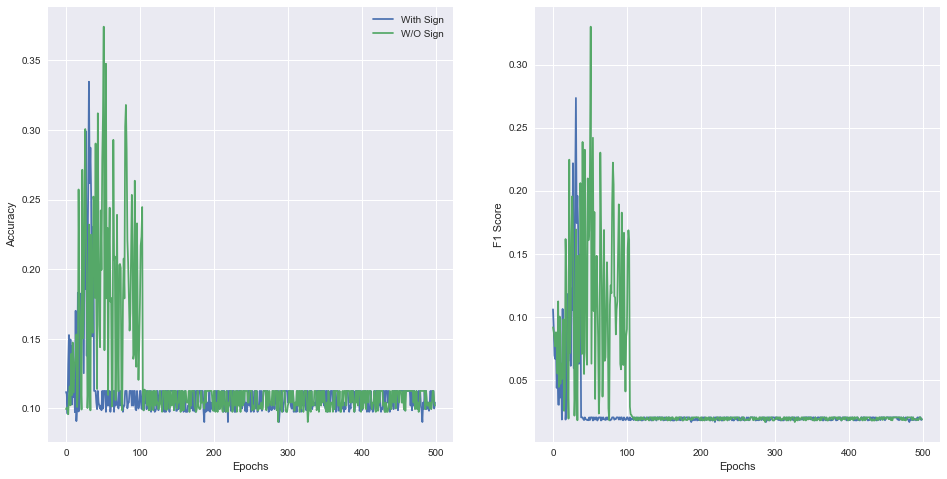

In [18]:
from pylab import rcParams
import matplotlib.pyplot as plt
plt.style.use('seaborn')
rcParams['figure.figsize'] = 16, 8
fig, ax = plt.subplots(ncols=2, nrows=1)
ax[0].grid(True)
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].plot(np.loadtxt('data/acc_with_sign.csv', delimiter=','), label='With Sign')
ax[0].plot(np.loadtxt('data/acc_without_sign.csv', delimiter=','), label='W/O Sign')
ax[0].legend()


ax[1].grid(True)
ax[1].set_ylabel('F1 Score')
ax[1].set_xlabel('Epochs')
ax[1].plot(np.loadtxt('data/f1_with_sign.csv', delimiter=','), label='With Sign')
ax[1].plot(np.loadtxt('data/f1_without_sign.csv', delimiter=','), label='W/O Sign')
ax[0].legend()
plt.show()

In [19]:
# Actual watermark the model was trained with
watermark = "www.uis.no"
sign = model.predict(signcoder.get_sign(watermark, 256).reshape(1,-1))
print(signcoder.sign_error(watermark=watermark, sign=sign))

# false watermarks
watermark = "ww.uis.no"
sign = model.predict(signcoder.get_sign(watermark, 256).reshape(1,-1))
print(signcoder.sign_error(watermark=watermark, sign=sign))

watermark = "www.vis.no"
sign = model.predict(signcoder.get_sign(watermark, 256).reshape(1,-1))
print(signcoder.sign_error(watermark=watermark, sign=sign))

watermark = "Anything Else"
sign = model.predict(signcoder.get_sign(watermark, 256).reshape(1,-1))
print(signcoder.sign_error(watermark=watermark, sign=sign))

0.00479986
0.9562624
0.73729726
1.53671271


In [20]:
model.predict(signcoder.get_sign("www.uis.no", 256).reshape(1,-1))

array([[ 0.8925554 ,  0.69435906, -1.4444867 ,  0.8595681 , -1.4221269 ,
         0.5061548 ,  0.8557311 , -0.94027305,  0.8921833 ,  0.71279866]],
      dtype=float32)

In [21]:
signcoder.get_sign("www.uis.no", 10)

array([ 0.88989094,  0.71135253, -1.44874346,  0.86011465, -1.41827776,
        0.50427744,  0.84309043, -0.94170477,  0.88989094,  0.71135253])

In [22]:
y_pred = model.predict(x_test)
y_pred = np.apply_along_axis(np.argmax, 1, y_pred)
y_true = np.apply_along_axis(np.argmax, 1, y_test)
accuracy_score(y_true, y_pred)

0.10417142857142857

In [23]:
new_sign = signcoder.get_sign("new watermark", 256)
new_x_train = np.ones((5000, 256))
for i in range(new_x_train.shape[0]):
    new_x_train[i] = new_sign

new_sign = signcoder.get_sign("new watermark", 10)
new_y_train = np.ones((5000, 10))
for i in range(new_y_train.shape[0]):
    new_y_train[i] = new_sign

In [24]:
EPOCHS = 5

model_accuracy = np.zeros((EPOCHS))
model_f1 = np.zeros((EPOCHS))
og_sign_error = np.zeros((EPOCHS))
new_sign_error = np.zeros((EPOCHS))

for i in range(EPOCHS):
    y_pred = model.predict(x_test)
    y_pred = np.apply_along_axis(np.argmax, 1, y_pred)
    y_true = np.apply_along_axis(np.argmax, 1, y_test)
    model_accuracy[i] = accuracy_score(y_true, y_pred)

    sign = model.predict(signcoder.get_sign("www.uis.no", 256).reshape(1,-1))
    og_sign_error[i] = signcoder.sign_error(watermark="www.uis.no", sign=sign)

    sign = model.predict(signcoder.get_sign("new watermark", 256).reshape(1,-1))
    new_sign_error[i] = signcoder.sign_error(watermark="new watermark", sign=sign)

    history = model.fit(new_x_train, new_y_train, **train_parameters, signature=sig)

Train model with signature of size 13300
Train on 5000 samples, validate on 17500 samples
5000/5000 [==============================] - 8s 2ms/sample - loss: 0.2776 - mean_absolute_error: 0.3680 - val_loss: 0.8950 - val_mean_absolute_error: 0.8315
Train model with signature of size 13300
Train on 5000 samples, validate on 17500 samples
5000/5000 [==============================] - 8s 2ms/sample - loss: 0.0102 - mean_absolute_error: 0.0523 - val_loss: 1.0846 - val_mean_absolute_error: 0.9126
Train model with signature of size 13300
Train on 5000 samples, validate on 17500 samples
5000/5000 [==============================] - 9s 2ms/sample - loss: 8.7627e-04 - mean_absolute_error: 0.0123 - val_loss: 1.1266 - val_mean_absolute_error: 0.9290
Train model with signature of size 13300
Train on 5000 samples, validate on 17500 samples
5000/5000 [==============================] - 8s 2ms/sample - loss: 8.0105e-05 - mean_absolute_error: 0.0033 - val_loss: 1.1378 - val_mean_absolute_error: 0.9333
Trai

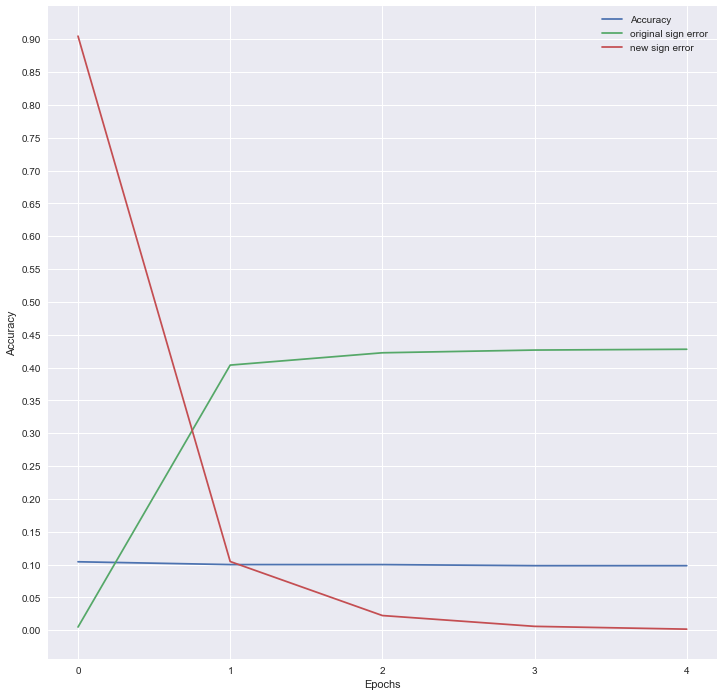

In [25]:
rcParams['figure.figsize'] = 12, 12
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.grid(True)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epochs')
ax.yaxis.set_ticks(np.arange(0, 1, 0.05))
ax.xaxis.set_ticks(np.arange(0, 5, 1))
ax.plot(model_accuracy, label='Accuracy')
ax.plot(og_sign_error, label='original sign error')
ax.plot(new_sign_error, label='new sign error')
ax.legend()

In [26]:
y_pred = model.predict(x_test)
y_pred = np.apply_along_axis(np.argmax, 1, y_pred)
y_true = np.apply_along_axis(np.argmax, 1, y_test)
accuracy_score(y_true, y_pred)

0.09822857142857143

In [27]:
watermark = "www.uis.no"
sign = model.predict(signcoder.get_sign(watermark, 256).reshape(1,-1))
print(signcoder.sign_error(watermark=watermark, sign=sign))

watermark = "new watermark"
sign = model.predict(signcoder.get_sign(watermark, 256).reshape(1,-1))
print(signcoder.sign_error(watermark=watermark, sign=sign))

watermark = "www.uit.no"
sign = model.predict(signcoder.get_sign(watermark, 256).reshape(1,-1))
print(signcoder.sign_error(watermark=watermark, sign=sign))

0.4281732
0.00041678
1.30719075
